# Derby Air Pollution Project

## Workflow

1) Get data from URL

2) Clean data

3) Plot graph per hour

4) Plot graph per day etc, do resampling

In [117]:
### Imports ###

from datetime import timedelta
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import seaborn as sns
import pandas as pd
from urllib.request import urlretrieve
from datetime import datetime

### Get data ###
URL_2020 = 'https://uk-air.defra.gov.uk/data_files/site_data/DESA_2020.csv'
URL_2019 = 'https://uk-air.defra.gov.uk/data_files/site_data/DESA_2019.csv'
URL_2018 = 'https://uk-air.defra.gov.uk/data_files/site_data/DESA_2018.csv'
URL_2017 = 'https://uk-air.defra.gov.uk/data_files/site_data/DESA_2017.csv' 

urlretrieve(URL_2020,'derby_2020.csv')
urlretrieve(URL_2019,'derby_2019.csv')
urlretrieve(URL_2018,'derby_2018.csv')
urlretrieve(URL_2017,'derby_2017.csv')

df_2020 = pd.read_csv('derby_2020.csv',skiprows=4) # (skipping top 4 rows as they're empty)
df_2019 = pd.read_csv('derby_2019.csv',skiprows=4)
df_2018 = pd.read_csv('derby_2018.csv',skiprows=4)
df_2017 = pd.read_csv('derby_2017.csv',skiprows=4)
unit = 'ugm^3'

### Cleaning data ###
# Issue with the data: 
# what should be "02-01-2020" and "00:00" is called "01-01-2020"  and "24:00" which Pandas doesn't like
# Need to take every instance where this happens and + 1 to the date and replace 24:00 with 00:00

def datetime_cleaner(variable):
    '''
    Function to take every date + time where date is i.e. 1/1/2020 24:00 and turn it into 2/1/2020 00:00
    Also removes redundant columns
    Doesn't set the index to the datetime though
    '''
    variable['Date'] = pd.to_datetime(variable['Date']).dt.strftime('%d-%m-%Y')
    variable['Date'] = pd.to_datetime(variable['Date'])

    # date + 1 for every 24th entry 
    counter = 0
    for i, row in variable.iterrows():
        counter += 1
        if counter % 24 == 0:
            value = variable.at[i,'Date'] + pd.Timedelta(1,unit='d')
            variable.at[i,'Date'] = value

    # cleaning up columns and data types in a really janky way
    variable['time'] = variable['time'].replace(to_replace='24:00',value='00:00')
    variable['Date String'] = variable['Date'].astype(str)
    variable['Date Time String'] = variable['Date String'] + " " + variable['time']
    variable['Date Time'] = pd.to_datetime(variable['Date Time String'])
    variable.drop(['Date','time','status','unit','status.1','unit.1','status.2','unit.2','Date String','Date Time String'],
                 axis=1,inplace=True)
    
    # setting index to be the date time
    variable.index = variable['Date Time']


datetime_cleaner(df_2020)
datetime_cleaner(df_2019)
datetime_cleaner(df_2018)
datetime_cleaner(df_2017)

# Make new dataframe containing all data
frames = [df_2017,df_2018,df_2019,df_2020]

df_all = pd.concat(frames)
df_all_index = df_all.copy()
df_all_index.index = df_all_index['Date Time']

# Exploratory data analysis

In [107]:
# function to let you decide date range to plot
def plot_date_range(dateinput,resample_string,plottype,aggregate):
    '''
    Parameters:
    dateinput = date string in format YYYY-MM-DD
    resample = string of 'H'/'D'/'W'/'M'
    plottype = string 'line' or 'bar'
    aggregate = string 'sum','average','median'
    '''
    resample_string = resample_string.upper() # just in case user were to input h instead of H
    
    # for title of chart
    if resample_string == 'H':
        title_string = 'Hourly'
    elif resample_string == 'D':
        title_string = 'Daily'
    elif resample_string == 'W':
        title_string = 'Weekly'
    elif resample_string == 'M':
        title_string = 'Monthly'
    
    # date to plot from 
    dateinput_datetime = datetime.strptime(dateinput,'%Y-%m-%d')
    
    # resampling based on input
    if resample_string == 'H':
        z = df_all_index[df_all_index.index>=dateinput_datetime]
        if plottype == 'line':
            x = z[['Nitric oxide','Nitrogen dioxide']].plot(figsize=(15,10))
        elif plottype == 'bar':
            x = z[['Nitric oxide','Nitrogen dioxide']].plot.bar(figsize=(15,10))
        x.set_title('Hourly Emissions Since {}'.format(dateinput))
        x.set_ylim(0)
    else:    
        z = df_all_index[df_all_index.index>=dateinput_datetime]
        if plottype == 'line':
            if aggregate == 'sum':
                x = z[['Nitric oxide','Nitrogen dioxide']].resample(resample_string).sum().plot(figsize=(15,10))
            elif aggregate == 'mean':
                x = z[['Nitric oxide','Nitrogen dioxide']].resample(resample_string).mean().plot(figsize=(15,10))
            elif aggregate == 'median': 
                x = z[['Nitric oxide','Nitrogen dioxide']].resample(resample_string).median().plot(figsize=(15,10))
            x.set_title('{} {} Emissions Since {}'.format(aggregate.title(),title_string,dateinput))
            x.set_ylim(0)
        elif plottype == 'bar':
            if aggregate == 'sum':
                x = z[['Nitric oxide','Nitrogen dioxide']].resample(resample_string).sum().plot.bar(figsize=(15,10))
            elif aggregate == 'mean':
                x = z[['Nitric oxide','Nitrogen dioxide']].resample(resample_string).mean().plot.bar(figsize=(15,10))
            elif aggregate == 'median':
                x = z[['Nitric oxide','Nitrogen dioxide']].resample(resample_string).median().plot.bar(figsize=(15,10))
            x.set_title('{} {} Emissions Since {}'.format(aggregate.title(),title_string,dateinput))
            x.set_ylim(0)

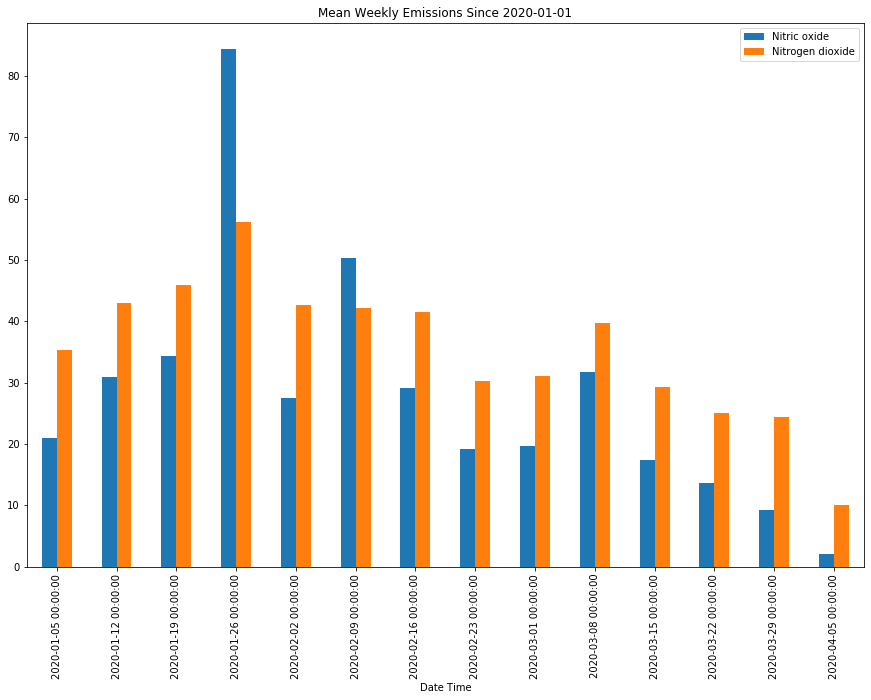

In [220]:
plot_date_range('2020-01-01','W','bar','mean')

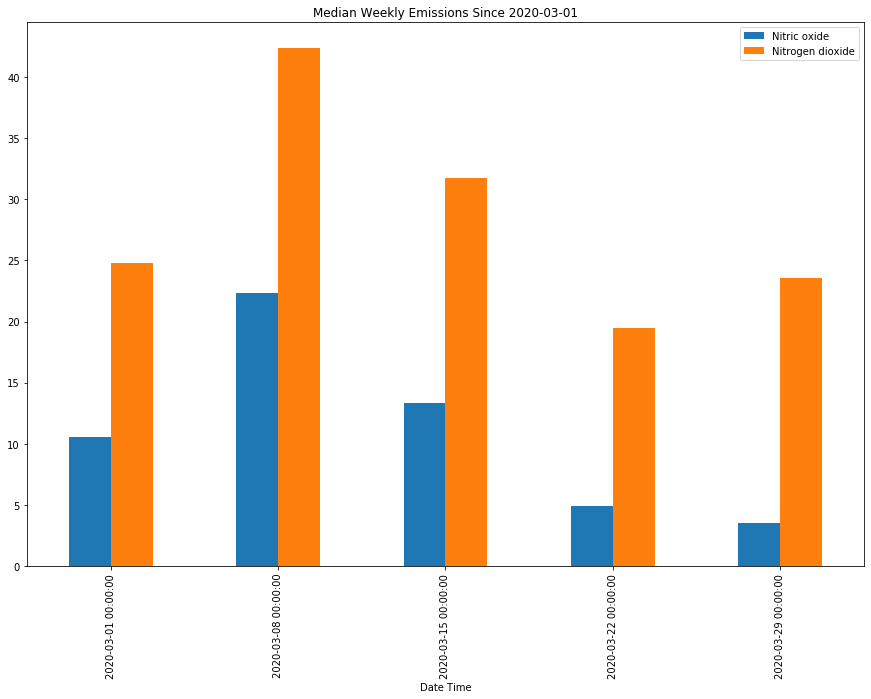

In [7]:
plot_date_range('2020-03-01','W','bar','median')

# Rolling mean

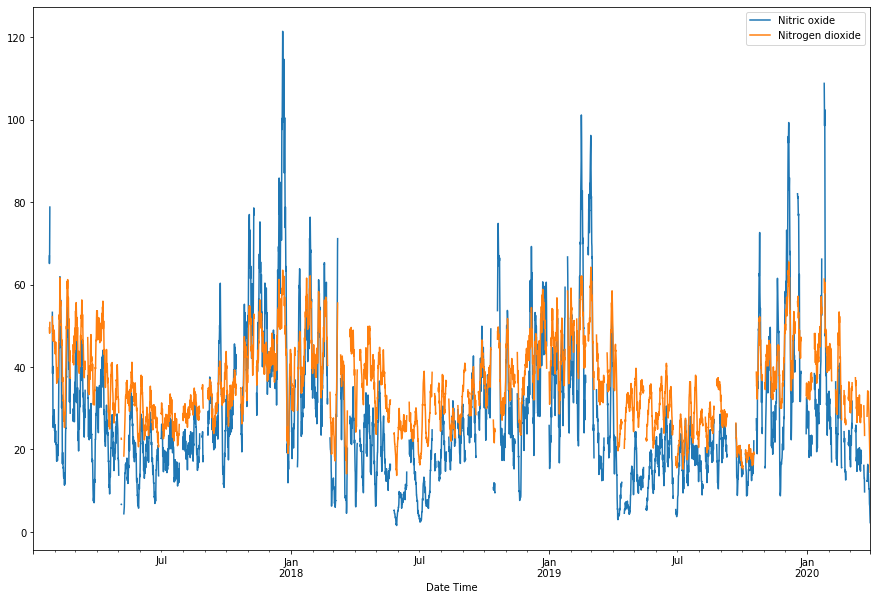

In [216]:
df_all_index[['Nitric oxide','Nitrogen dioxide']].rolling(84).mean().plot(figsize=(15,10))

# Year comparison subplot
- Hideous 

In [3]:
# user enters start and end date to compare in format 'MM-DD'
# mask of each year to only show between these dates
# make plot for each year and stack them on top of each other as subplots

def year_comparison(start,end,resample_string):
    global df_2020, df_2019, df_2018, df_2017
    '''
    Parameters:
    start = string of date in format 'MM-DD'
    end = string of date in format 'MM-DD'
    resample_string = 'H','D','W','M'
    '''
    # below is hideous but I'm just doing it in this dumb way because I know it'll work
    # gets you start and end dates for each year
    start_2020 = '2020-' + start
    start_2020 = pd.to_datetime(start_2020)
    end_2020 = '2020-' + end
    end_2020 = pd.to_datetime(end_2020)
    
    start_2019 = '2019-' + start
    start_2019 = pd.to_datetime(start_2019)
    end_2019 = '2019-' + end
    end_2019 = pd.to_datetime(end_2019)
       
    start_2018 = '2018-' + start
    start_2018 = pd.to_datetime(start_2018)
    end_2018 = '2018-' + end
    end_2018 = pd.to_datetime(end_2018)
    
    start_2017 = '2017-' + start
    start_2017 = pd.to_datetime(start_2017)
    end_2017 = '2017-' + end
    end_2017 = pd.to_datetime(end_2017)
    
    ### MASKS ###
    # 2020
    mask = (df_2020['Date Time'] >= start_2020) & (df_2020['Date Time'] <= end_2020)
    df_2020 = df_2020.loc[mask]
    # 2019
    mask = (df_2019['Date Time'] >= start_2019) & (df_2019['Date Time'] <= end_2019)
    df_2019 = df_2019.loc[mask]
    # 2018
    mask = (df_2018['Date Time'] >= start_2018) & (df_2018['Date Time'] <= end_2018)
    df_2018 = df_2018.loc[mask]
    # 2017
    mask = (df_2017['Date Time'] >= start_2017) & (df_2017['Date Time'] <= end_2017)
    df_2017 = df_2017.loc[mask]

    ### MAKE SUBPLOTS ###
    # Subplot layout - 4 long plots on top of each other 

    if resample_string == 'H':    
        f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharey=True,figsize=(16,16))
        ax1.plot(df_2020.index, df_2020['Nitric oxide'])
        ax1.set_title('2020')
        ax2.plot(df_2019.index, df_2019['Nitric oxide'])
        ax1.set_title('2019')
        ax3.plot(df_2018.index, df_2018['Nitric oxide'])
        ax1.set_title('2018')
        ax4.plot(df_2017.index, df_2017['Nitric oxide'])
        ax1.set_title('2018')

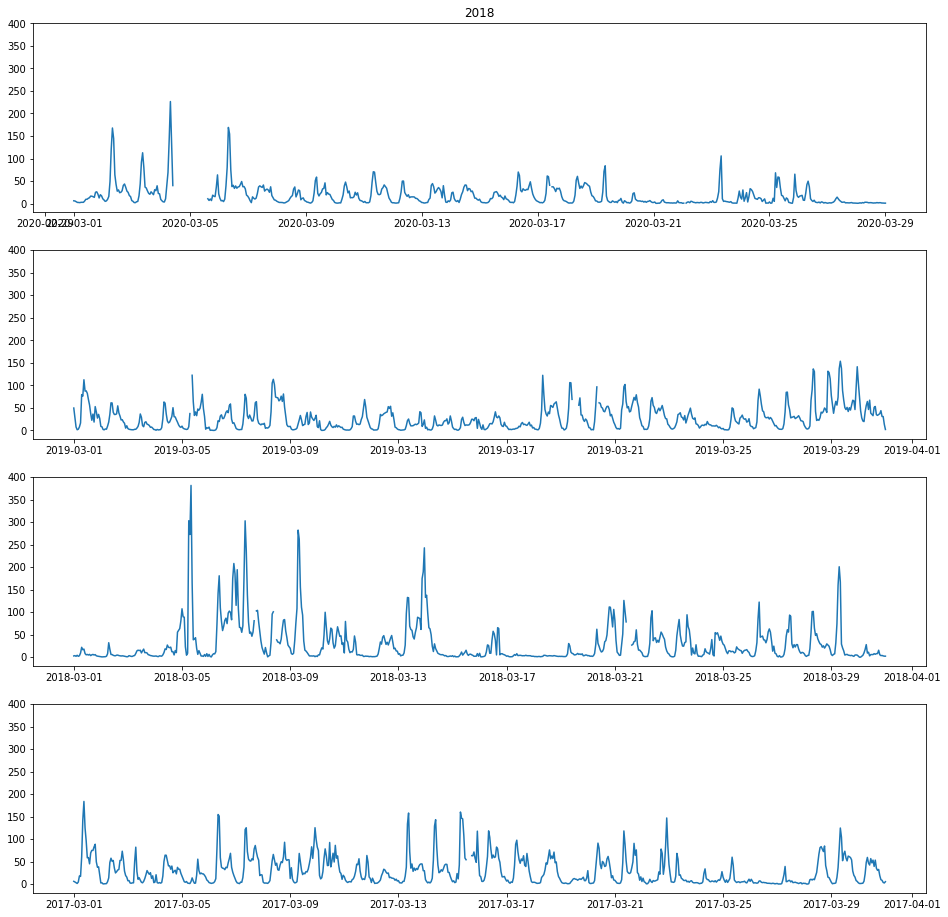

In [74]:
year_comparison('03-01','03-31','H')

# Year comparison - on one plot
- First, make a function that creates variable masks of each dataframe
- Then strip the year from these maps 
- Then plot on one graph!

In [209]:
# user enters start and end date to compare in format 'MM-DD'
# mask of each year to only show between these dates
# make plot for each year and stack them on top of each other as subplots

def year_comparison(start,end,resample_string):
    global df_2020, df_2019, df_2018, df_2017
    '''
    Parameters:
    start = string of date in format 'MM-DD'
    end = string of date in format 'MM-DD'
    resample_string = 'H','D','W','M'
    '''
   
    # below is hideous but I'm just doing it in this dumb way because I know it'll work
    # gets you start and end dates for each year
    start_2020 = '2020-' + start
    start_2020 = pd.to_datetime(start_2020)
    end_2020 = '2020-' + end
    end_2020 = pd.to_datetime(end_2020)
    
    start_2019 = '2019-' + start
    start_2019 = pd.to_datetime(start_2019)
    end_2019 = '2019-' + end
    end_2019 = pd.to_datetime(end_2019)
       
    start_2018 = '2018-' + start
    start_2018 = pd.to_datetime(start_2018)
    end_2018 = '2018-' + end
    end_2018 = pd.to_datetime(end_2018)
    
    start_2017 = '2017-' + start
    start_2017 = pd.to_datetime(start_2017)
    end_2017 = '2017-' + end
    end_2017 = pd.to_datetime(end_2017)
    
    ### MASKS ###
    # 2020
    mask = (df_2020['Date Time'] >= start_2020) & (df_2020['Date Time'] <= end_2020)
    df_2020_ = df_2020.loc[mask]
    # 2019
    mask = (df_2019['Date Time'] >= start_2019) & (df_2019['Date Time'] <= end_2019)
    df_2019_ = df_2019.loc[mask]
    # 2018
    mask = (df_2018['Date Time'] >= start_2018) & (df_2018['Date Time'] <= end_2018)
    df_2018_ = df_2018.loc[mask]
    # 2017
    mask = (df_2017['Date Time'] >= start_2017) & (df_2017['Date Time'] <= end_2017)
    df_2017_ = df_2017.loc[mask]
    
    if resample_string=='H':
        ### Making date time no year column
        df_2020_['Date Time No Year'] = df_2020_['Date Time'].dt.strftime('%m-%d %H:%M')
        df_2019_['Date Time No Year'] = df_2019_['Date Time'].dt.strftime('%m-%d %H:%M')
        df_2018_['Date Time No Year'] = df_2018_['Date Time'].dt.strftime('%m-%d %H:%M')
        df_2017_['Date Time No Year'] = df_2017_['Date Time'].dt.strftime('%m-%d %H:%M')

        ### Plotting them with date time no year
        plt.figure(figsize=(15,10))
        sns.lineplot(x=df_2020_['Date Time No Year'],y=df_2020_['Nitric oxide'])
        sns.lineplot(x=df_2019_['Date Time No Year'],y=df_2019_['Nitric oxide'])
        #sns.lineplot(x=df_2018_['Date Time No Year'],y=df_2018_['Nitric oxide'])
        #sns.lineplot(x=df_2017_['Date Time No Year'],y=df_2017_['Nitric oxide'])
    
    elif resample_string!='H':
        ### Resample accordingly 
        plt.figure(figsize=(15,10))
        df_2020_ = df_2020_.resample(resample_string).sum()
        df_2019_ = df_2019_.resample(resample_string).sum()
        df_2018_ = df_2018_.resample(resample_string).sum()
        df_2017_ = df_2017_.resample(resample_string).sum()
        # this strips away the Date Time No Year column, have to make a new one
        
        ### Making date time no year column
        df_2020_['Date Time No Year'] = df_2020_.index.strftime('%m-%d %H:%M')
        df_2019_['Date Time No Year'] = df_2019_.index.strftime('%m-%d %H:%M')
        df_2018_['Date Time No Year'] = df_2018_.index.strftime('%m-%d %H:%M')
        df_2017_['Date Time No Year'] = df_2017_.index.strftime('%m-%d %H:%M')
        
        #### Replacing date time as index as removing datatime column 
        def cleaner(variable):
            variable.index = variable['Date Time No Year']
        #    variable.drop(['Date Time'],axis=1)
        
        cleaner(df_2020_)
        cleaner(df_2019_)
        cleaner(df_2018_)
        cleaner(df_2017_)
        
        #return df_2017_
        
        ### Plotting them with date time no year
        plt.figure(figsize=(15,10))
        plt.title('aah')
        sns.lineplot(x=df_2020_['Date Time No Year'],y=df_2020_['Nitric oxide'],
                     label='2020',linestyle='-',marker='o',alpha=1)
        sns.lineplot(x=df_2019_['Date Time No Year'],y=df_2019_['Nitric oxide'],label='2019',linestyle=':',alpha=0.4)
        sns.lineplot(x=df_2018_['Date Time No Year'],y=df_2018_['Nitric oxide'],label='2018',alpha=0.4,linestyle=':')
        sns.lineplot(x=df_2017_['Date Time No Year'],y=df_2017_['Nitric oxide'],label='2017',alpha=0.4,linestyle=':')
        
        

<Figure size 1080x720 with 0 Axes>

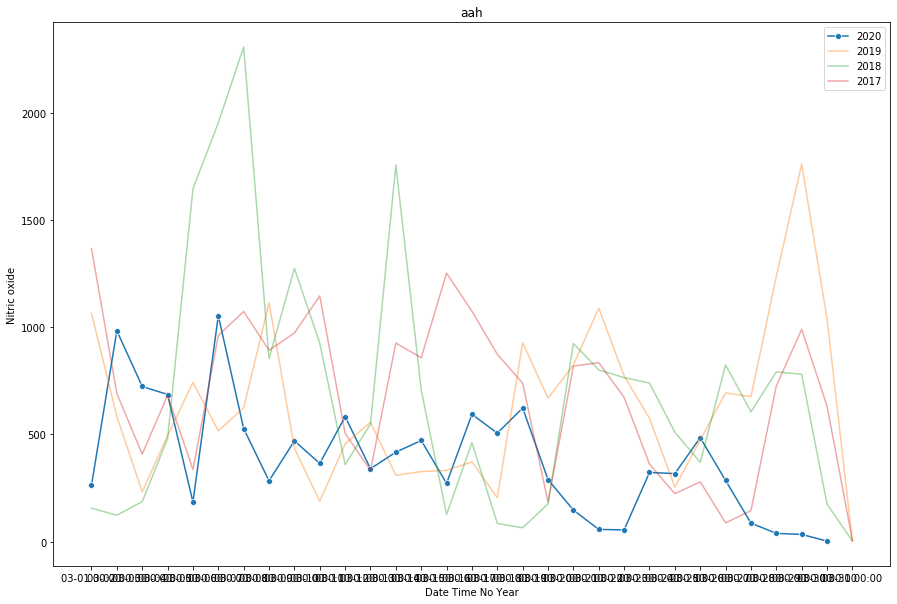

In [218]:
year_comparison('03-01','03-31','D')

- Resample all data by *week* doesn't work 
- Probably because different years have different weeks?
- Needs a legend, title etc
- Would also be great to specify how many years to plot i.e. don't show all 4

## Potential workaround for resampling each year by week:
- manually group each year by 1st to 7th of Jan etc?